In [0]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import random
import itertools
import time
from random import randint
import tqdm

# Load instance

In [0]:
instance_number = 0  # 0 - "kroA200.tsp"    1 - "kroB200.tsp"
instances_names = ["kroA200.tsp","kroB200.tsp"]
data = np.genfromtxt(f'{instances_names[instance_number]}', skip_header=6, skip_footer=1, dtype='int64')[:,1:]

# Calculating distance matrix

In [0]:
def calc_distance_matrix(data):
    dist_matrix = distance_matrix(data, data)
    dist_matrix = np.around(dist_matrix, decimals=0)
    dist_matrix = dist_matrix.astype(int)
    return dist_matrix

In [0]:
distance_matrix = calc_distance_matrix(data)
distance_matrix

array([[   0, 1700, 1846, ...,  452, 1163, 2616],
       [1700,    0, 1118, ..., 1250, 2651, 1504],
       [1846, 1118,    0, ..., 1536, 2320, 2615],
       ...,
       [ 452, 1250, 1536, ...,    0, 1535, 2228],
       [1163, 2651, 2320, ..., 1535,    0, 3760],
       [2616, 1504, 2615, ..., 2228, 3760,    0]])

# ILS2

In [0]:
def random_path(length, dataset_size):
    points = np.arange(dataset_size)
    np.random.shuffle(points)
    path, outside = points[:length], points[length:]
    return path, outside

In [0]:
def path_length(path):
	length = 0
	for i in range(len(path)-1):
		length += distance_matrix[path[i], path[i+1]]

	length += distance_matrix[path[-1], path[0]]
	return length

In [0]:
def delta_change_outside(size, x, out, index, distance_matrix):
    i = index[0]
    j = index[1]

    old = distance_matrix[x[(i-1)%size], x[i]] + distance_matrix[x[i], x[(i+1)%size]]
    new = distance_matrix[x[(i-1)%size], out[j]] + distance_matrix[out[j], x[(i+1)%size]]
       
    return old - new

In [0]:
def delta_change_inside_edges(size, x, index, distance_matrix):
    i = index[0]
    j = index[1]
    
    old = distance_matrix[x[(i-1)%size], x[i]] + distance_matrix[x[j], x[(j+1)%size]]
    new = distance_matrix[x[(i-1)%size], x[j]] + distance_matrix[x[i], x[(j+1)%size]]
    
    return old - new

In [0]:
def swap_vertices_outside(x):
    idx = []
    for i in range(len(x)):
        for j in range(len(x)):
            idx.append([i, j])
        
    idx = np.array(idx)
    return idx

In [0]:
def swap_edges(x):
    combinations = itertools.combinations(np.arange(len(x)), 2)
    return np.array([[v1,v2] for v1, v2 in combinations if 1 < v2 - v1 < len(x) - 1 ], 'int')

In [0]:
def destroy(x, size):
    path = path_length(x)
    average = path/size
    start = randint(0, size-21)
    for i in range(start, len(x)-21, 2):
        distance = 0
        for j in range(20):
            distance += distance_matrix[x[i+j]][x[i+j+1]]
        if distance/20 > average:
            return i
        
    return randint(0, size-21)

In [0]:
def repair(x, out, idx):
    for i in range(20):
        nn = nearest_neigh(x[idx+i], out)
        x[idx+i+1] = nn
        out = np.setdiff1d(out, [nn])
    return x

In [0]:
def nearest_neigh(point, out):
    near = []
    i = 0
    sorted_distances = np.argsort(distance_matrix[point])[1:]
    for elem in sorted_distances:
        if elem in out and i < 3:
          near.append(elem)
          i += 1
    idx = randint(0, 2)
    return near[idx]

In [0]:
def steepest_edge(size, start, out):
    x = start
    N_in = swap_edges(x)
    N_out = swap_vertices_outside(x)
    while True:
        max_diff_o = 0
        idx_o = 0
        for id in range(len(N_out)):
            idx = N_out[id]
            diff = delta_change_outside(size, x, out, idx, distance_matrix)
            if diff > max_diff_o:
                max_diff_o = diff
                idx_o = idx
        max_diff_i = 0
        idx_i = 0
        for id in range(len(N_in)):
            idx = N_in[id]
            diff = delta_change_inside_edges(size, x, idx, distance_matrix)
            if diff > max_diff_i:
                max_diff_i = diff
                idx_i = idx
                
        if (max_diff_i > 0) or (max_diff_o > 0):        
            # ruch zmieniający zbiór wierzchołków 
            if max_diff_o > max_diff_i:
                ver1 = x[idx_o[0]]
                ver2 = out[idx_o[1]]
                x[idx_o[0]] = ver2
                out[idx_o[1]] = ver1                
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)

            #ruch wewnątrztrasowy zamiana krawędzi
            else:
                a = x[idx_i[0]:idx_i[1]+1]
                a = np.flip(a)
                x[idx_i[0]:idx_i[1]+1] = a
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)
        else:
            break
            
    return x

In [0]:
def return_out(x):
  out = np.arange(200)
  out = np.setdiff1d(out, x)
  return out

In [0]:
def ILS2(size, x, out):
  x = steepest_edge(100, x, out)
  start_time = time.time()
  iteration = 0 
  while time.time() - start_time < 1050:
    out = return_out(x)
    idx = destroy(x, 100)
    path = np.copy(x)
    permutation = repair(path, out, idx)
    out = return_out(permutation)
    new_x = steepest_edge(100, permutation, out)
    iteration += 1
    if path_length(x) > path_length(new_x):
      x = new_x

  return x, iteration

In [0]:
MIN = 1000000
MAX = 0
SUM = 0
T_MIN = 1000000
T_MAX = 0
T_SUM = 0
max_iter = 0
min_iter = 100000
sum_iter = 0
for i in range(10):
  print(i)
  x, out = random_path(100, 200)
  start_time = time.time()
  x, iteration = ILS2(100, x, out)
  t = time.time() - start_time
  len_x = path_length(x)
    
  if len_x > MAX:
        MAX = len_x
  if len_x < MIN:
        MIN = len_x
        T = x
  SUM += len_x
    
  if t > T_MAX:
        T_MAX = t
  if t < T_MIN:
        T_MIN = t
  T_SUM += t

  if iteration > max_iter:
        max_iter = iteration
  if iteration < min_iter:
        min_iter = iteration
  sum_iter += iteration


0
1
2
3
4
5
6
7
8
9


In [0]:
print(min_iter)
print(sum_iter/10)
print(max_iter)

572
601.9
659


In [0]:
print(MIN)
print(MAX)
print(SUM/10)

13942
14609
14241.9


In [0]:
#time
print(T_MIN)
print(T_MAX)
print(T_SUM/10)

1012.0600700378418
1014.8806157112122
1013.1098821163177


In [0]:
def print_plot(data, points):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points, 0], data[points, 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points, 0], data[points, 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("ILS2 - kroB200")
    plt.grid(False)
    
    plt.show()
    f.savefig('ILS2B.pdf', bbox_inches='tight')

In [0]:
T = np.append(T, T[0])
T

array([ 56,  93, 179, 175,  26,  60,  34, 171, 156, 177, 130, 198, 144,
        65, 132, 167, 113, 164,  73,  59, 185, 195,  51,  53, 162, 153,
       190, 114,  71,  36, 183, 140,  64, 123, 126, 187,  78, 178, 112,
        99,  55, 100, 149,  25,  61, 131,   4, 193, 116,  39,  38, 197,
        69, 148, 169,  52,  72,  84, 121,  92,  10, 157,  27, 128,  90,
        98,  28,   7, 135,  58, 174, 166,  31, 106,  70, 160,  11, 173,
         0,  94,  89,  20, 107, 165, 137,  85,  48, 133, 180,  29,  74,
        79,  19,  37, 145,  45,  24,  33,  83,   6,  56,  56])

In [0]:
len(np.unique(T))

100

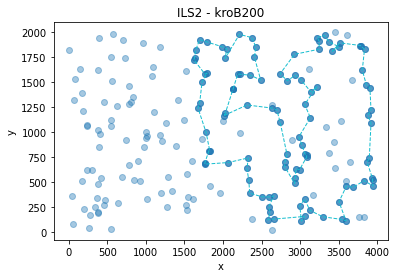

In [0]:
print_plot(data, T)